<a href="https://colab.research.google.com/github/spchanakya/Food-Quality-Classification/blob/main/Main_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# import important Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import seaborn as sn
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import accuracy_score,confusion_matrix,roc_auc_score,roc_curve,classification_report,auc,mean_absolute_error
from keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.applications import MobileNetV2
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model,Sequential
from keras.optimizers import Adam,SGD
from keras.utils import to_categorical


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

!git clone https://github.com/spchanakya/Food-Quality-Classification.git


fatal: destination path 'Food-Quality-Classification' already exists and is not an empty directory.


# important functions

In [ ]:
def plot_conf_matrix(A,B,C=str(''),D=str(' ')):
  conf_matrix = confusion_matrix(A,B)
  plt.figure(figsize=(6,5))
  sn.heatmap(conf_matrix,annot=True, fmt='', cmap='rocket_r')
  title="Confusion Matrix for "+str(C)+" "+str(D)
  plt.title(title)
  plt.ylabel('Predicted Class')
  plt.xlabel('Target Class')
  plt.savefig(str(title))
  plt.show()
  return()
def plot_classification_report(A,B):
  print('\n*Classification Report:\n', classification_report(A,B))
  return()
def plot_ROC_details(A,B):
  fpr, tpr, thresholds = roc_curve(A,B,pos_label=1)
  auc=roc_auc_score(A,B,average='macro')
  print("AUC :%.3f" %auc)
  acc_score=accuracy_score(A,B)
  print("Accuracy score :%.3f" %acc_score)
  fig, ax = plt.subplots(figsize=(6, 6))
  plt.plot(fpr, tpr, label='ROC Curve 1 (AUC = %0.2f)' )
  plt.title("ROC curve")
  plt.xlabel('False positive rate')
  plt.ylabel('True positive rate')
  plt.show()
  return()
def plot_acc_loss_curve(A,B,C = str(' ')):
  result_df = pd.DataFrame(A.history)
  fig, ax=plt.subplots(nrows=1, ncols=2,figsize=(18,6))
  ax=ax.flatten()
  ax[0].plot(result_df[['accuracy','val_accuracy']])
  ax[0].set_title("Accuracy")
  ax[0].set_ylim(0,1.01)
  ax[0].set_ylabel("Accuracy") # yaxis for left side plot
  ax[0].set_xlabel("Epochs")# xaxis for left side plot
  ax[0].legend(['Training_Accuracy', 'val_accuracy'], loc='upper left')
  ax[1].plot(result_df[['loss','val_loss']])
  ax[1].set_title("Loss")
  ax[1].set_ylabel("Loss")# yaxis for right side plot
  ax[1].set_xlabel("Epochs")# xaxis for right side plot
  ax[1].legend(['Training_Loss', 'val_loss'], loc='upper right')
  if C == str(' '):
    title='Results of '+ str(B) +' Model'
    fig.suptitle(title, fontsize=16)
    plt.savefig(str(title))
  else:
    title='Results of '+ str(B) +' Model for '+str(C)+'classification'
    fig.suptitle(title, fontsize=16)
    plt.savefig(str(title))
  return()

In [ ]:
def data_categorical(y):            # to convert the data into numerical labels
  labels = pd.Categorical(y)
  num_classes = len(labels.categories)
  return to_categorical(labels.codes, num_classes=num_classes)


# Preparing the data

## Loading the dataset into pandas dataset

In [ ]:
Training_data = '/content/Food-Quality-Classification/Final_Dataset/Train' # This is a sample of the whole Training dataset I am using
Test_data = '/content/Food-Quality-Classification/Final_Dataset/Test' # This is a sample of the whole test dataset I am using

In [ ]:
img_shape=(224,224) # target image size

In [ ]:
import os
from PIL import Image
def Create_DF(i):
  folder_path=i
  data = {'Image': [], 'FolderName': []}
  for folder_name in os.listdir(folder_path):
      folder_full_path = os.path.join(folder_path, folder_name)
      if os.path.isdir(folder_full_path):
          for image_file in os.listdir(folder_full_path):
              if image_file.endswith('.jpg') or image_file.endswith('.png'):
                  image_path = os.path.join(folder_full_path, image_file)
                  img = Image.open(image_path)
                  img = img.resize(img_shape)
                  img_array = np.array(img)
                  data['Image'].append(img_array)
                  data['FolderName'].append(folder_name)
  df = pd.DataFrame(data)
  return df

In [ ]:
Train_df=Create_DF(Training_data)
Test_df=Create_DF(Test_data)

In [15]:
# prompt: save Train_df and test_df as pikcles in food_quality class

import pickle
with open('/content/Food-Quality-Classification/Train_df.pkl', 'wb') as f:
  pickle.dump(Train_df, f)
with open('/content/Food-Quality-Classification/Test_df.pkl', 'wb') as f:
  pickle.dump(Test_df, f)

## loading the dataframe

In [ ]:
# #loading the Dataset
# import pickle

# with open('/content/drive/MyDrive/Train_df.pkl', 'rb') as file:
#     Train_df = pickle.load(file)
# with open('/content/drive/MyDrive/Test_df.pkl', 'rb') as file:
#     Test_df = pickle.load(file)


In [21]:
!git config --global user.email "spranavchanbakya@gmail.com"
!git config --global user.name "spchanakya"

In [23]:
!git clone git@github.com:spchanakya/Food-Quality-Classification.git

Cloning into 'Food-Quality-Classification'...
Host key verification failed.
fatal: Could not read from remote repository.

Please make sure you have the correct access rights
and the repository exists.


In [22]:
# %cd Food-Quality-Classification
!git add Train_df.pkl
!git commit -m "Train_dataframe"
!git push

[main 5a24eaba] Train_dataframe
 1 file changed, 0 insertions(+), 0 deletions(-)
 create mode 100644 Train_df.pkl
fatal: could not read Username for 'https://github.com': No such device or address


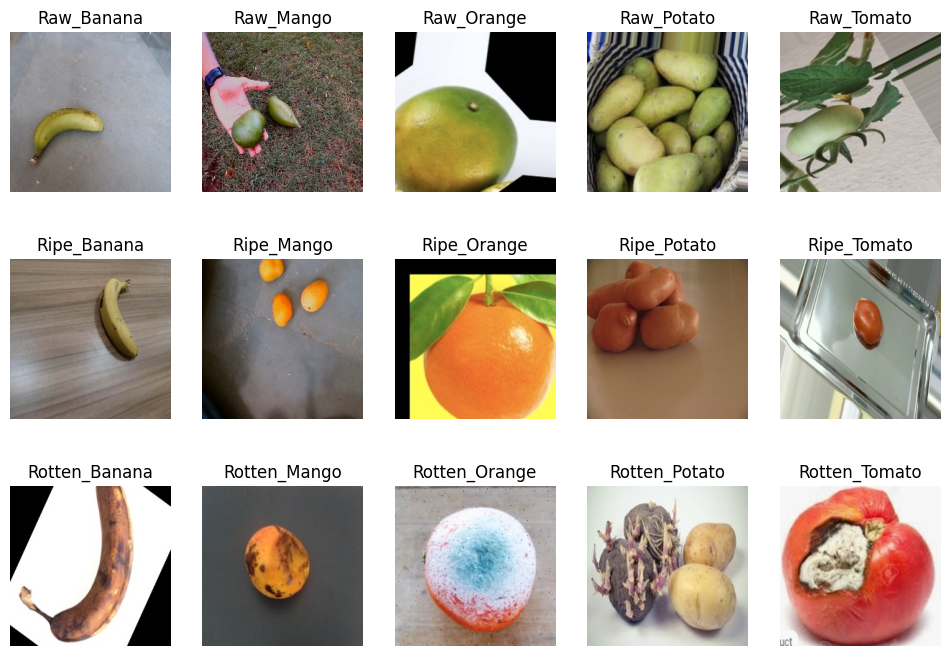

In [ ]:
# display one sample per class in the dataset
fig, axs = plt.subplots(3, 5, figsize=(12, 8))
fig.subplots_adjust(hspace=0.4)
for i, (key, grp) in enumerate(Train_df.groupby('FolderName')):
    image_array = grp.iloc[0]['Image']
    axs[i // 5, i % 5].imshow(image_array)
    axs[i // 5, i % 5].set_title(key[2:])
    axs[i // 5, i % 5].axis('off')
plt.savefig("Dataset sample images.jpg")
plt.show()

In [ ]:
# dataset formating based on type and ripeness lable
Train_df['N'] ,Train_df['Quality'], Train_df['Type']=Train_df['FolderName'].str.split('_',2).str
Test_df['N'] ,Test_df['Quality'], Test_df['Type']=Test_df['FolderName'].str.split('_',2).str
Test_df.drop(['N'], axis=1, inplace=True)
Train_df.drop(['N'], axis=1, inplace=True)
Train_df2 = Train_df.copy()
Test_df2= Test_df.copy()


In [ ]:
# code to make the train dataset all classes equal to 1000 samples
for i in Train_df2.FolderName.unique():
    if Train_df2[Train_df2['FolderName']==i].shape[0] < 500:
        temp = Train_df2[Train_df2['FolderName']==i]
        temp = temp.sample(frac=1, replace=True)
        Train_df2 = Train_df2.append(temp, ignore_index=True)
for i in Train_df2.FolderName.unique():
    if Train_df2[Train_df2['FolderName']==i].shape[0] > 1000:
        temp = Train_df2[Train_df2['FolderName']==i]
        temp = temp.head(1000)
        Train_df2 = Train_df2[Train_df2['FolderName']!=i]
        Train_df2 = Train_df2.append(temp, ignore_index=True)



In [ ]:
# code to make all classes in test df equal to 100 samples
for i in Test_df2.FolderName.unique():
    if Test_df2[Test_df2['FolderName']==i].shape[0] > 100:
        temp = Test_df2[Test_df2['FolderName']==i]
        temp = temp.head(100)
        Test_df2 = Test_df2[Test_df2['FolderName']!=i]
        Test_df2 = Test_df2.append(temp, ignore_index=True)

<Axes: xlabel='count', ylabel='FolderName'>

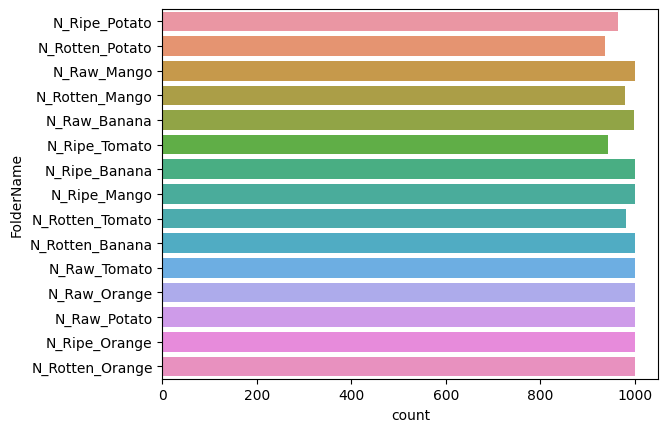

In [ ]:
# code to represent the count of each class (15 classes) in train Dataset
sns.countplot(data=Train_df2, y='FolderName')


<Axes: xlabel='count', ylabel='FolderName'>

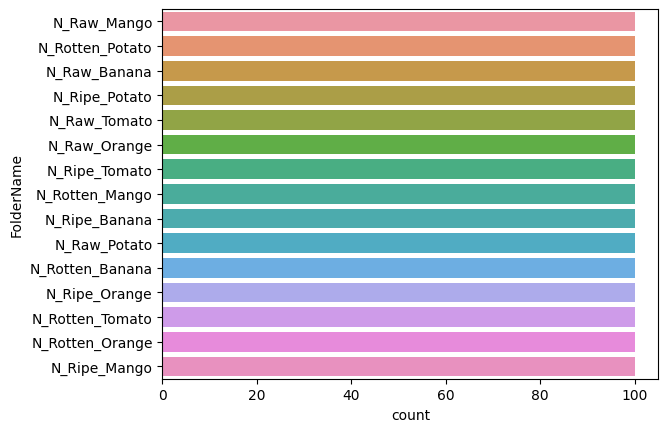

In [ ]:
# code to represent the count of each class (15 classes) in test Dataset
sns.countplot(data=Test_df2, y='FolderName')

# Deep learning with one classifier

## Data split

In [ ]:
X_train = np.stack(Train_df2['Image'].values)
Y_train = np.stack(Train_df2['FolderName'].values)
X_test = np.stack(Test_df2['Image'].values)
Y_test = np.stack(Test_df2['FolderName'].values)

In [ ]:
num_samples, height, width, channels = X_train.shape
num_classes = pd.unique(Y_train).shape[0]

## MNV2

### Pre Trained

In [ ]:
base_model_MNV2 = MobileNetV2(input_shape=(height, width, channels), include_top=False, weights='imagenet')
model_MNV2 = Sequential()
model_MNV2.add(base_model_MNV2)
model_MNV2.add(GlobalAveragePooling2D())
model_MNV2.add(Dense(256, activation='relu'))
model_MNV2.add(Dense(num_classes, activation='softmax'))
learning_rate = 0.001
model_MNV2.compile(optimizer=Adam(lr=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
batch_size = 128
epochs = 10
validation_split=0.25
MNV2_history = model_MNV2.fit(X_train, data_categorical(Y_train) , batch_size=batch_size, epochs=epochs, validation_split=validation_split)

Epoch 1/10
87/87 [==============================] - 16s 132ms/step - loss: 0.1938 - accuracy: 0.9423 - val_loss: 39.4235 - val_accuracy: 0.0054
Epoch 2/10
87/87 [==============================] - 10s 117ms/step - loss: 0.0643 - accuracy: 0.9814 - val_loss: 54.2052 - val_accuracy: 0.0000e+00
Epoch 3/10
87/87 [==============================] - 10s 117ms/step - loss: 0.0492 - accuracy: 0.9860 - val_loss: 33.4615 - val_accuracy: 0.0138
Epoch 4/10
87/87 [==============================] - 10s 117ms/step - loss: 0.0670 - accuracy: 0.9816 - val_loss: 44.2397 - val_accuracy: 0.0721
Epoch 5/10
87/87 [==============================] - 10s 117ms/step - loss: 0.0285 - accuracy: 0.9918 - val_loss: 38.8999 - val_accuracy: 0.1210
Epoch 6/10
87/87 [==============================] - 10s 118ms/step - loss: 0.0180 - accuracy: 0.9942 - val_loss: 35.1680 - val_accuracy: 0.1896
Epoch 7/10
87/87 [==============================] - 10s 118ms/step - loss: 0.0380 - accuracy: 0.9894 - val_loss: 37.6395 - val_accur

In [ ]:
y_pred_probs = model_MNV2.predict(X_test)
y_pred_labels = np.argmax(y_pred_probs, axis=1)
labels = pd.Categorical(Y_test)
y_pred_original_labels = pd.Categorical.from_codes(y_pred_labels, categories=labels.categories)
accuracy = np.sum(np.where(y_pred_labels == labels.codes ,1,0))/1500.  # here 1500 is the totoal number of test samples
print("Test accuracy for MNV2 single classifier classification:", accuracy)

47/47 [==============================] - 0s 8ms/step
Test accuracy for MNV2 single classifier classification: 0.8473333333333334


In [ ]:
plot_classification_report(labels,y_pred_original_labels)


*Classification Report:
                  precision    recall  f1-score   support

   N_Raw_Banana       0.99      0.95      0.97       100
    N_Raw_Mango       0.98      0.97      0.97       100
   N_Raw_Orange       1.00      0.99      0.99       100
   N_Raw_Potato       1.00      0.95      0.97       100
   N_Raw_Tomato       0.99      1.00      1.00       100
  N_Ripe_Banana       0.92      1.00      0.96       100
   N_Ripe_Mango       0.99      1.00      1.00       100
  N_Ripe_Orange       0.80      1.00      0.89       100
  N_Ripe_Potato       0.98      0.93      0.95       100
  N_Ripe_Tomato       0.97      0.99      0.98       100
N_Rotten_Banana       0.00      0.00      0.00       100
 N_Rotten_Mango       0.86      0.96      0.91       100
N_Rotten_Orange       0.00      0.00      0.00       100
N_Rotten_Potato       0.42      0.98      0.59       100
N_Rotten_Tomato       0.74      0.99      0.85       100

       accuracy                           0.85      1500
   

()

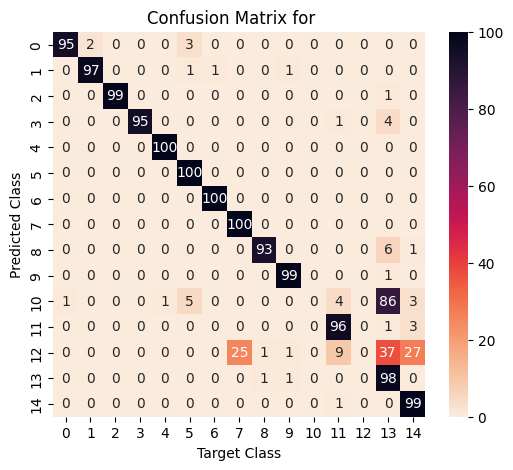

()

In [ ]:
plot_conf_matrix(labels.codes,y_pred_labels)

### Pretrained with Fine-Tuning

In [ ]:
base_model_MNV2 = MobileNetV2(input_shape=(height, width, channels), include_top=False, weights='imagenet')
for layer in base_model_MNV2.layers:
    layer.trainable = False
x = GlobalAveragePooling2D()(base_model_MNV2.output)
x = Dense(256, activation='relu')(x)
outputs = Dense(num_classes, activation='softmax')(x)
model_MNV2_FT = Model(inputs=base_model_MNV2.input, outputs=outputs) # Create the fine-tuned model
model_MNV2_FT.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])   # Complie the fine-tuned model
batch_size = 128
epochs = 10
validation_split=0.25
# Train the fine-Tuned Model
MNV2_FT_history = model_MNV2_FT.fit(X_train, data_categorical(Y_train), batch_size=batch_size, epochs=epochs, validation_split=validation_split)

Epoch 1/10
87/87 [==============================] - 7s 54ms/step - loss: 1.0045 - accuracy: 0.6845 - val_loss: 10.7006 - val_accuracy: 0.1310
Epoch 2/10
87/87 [==============================] - 3s 40ms/step - loss: 0.4844 - accuracy: 0.8534 - val_loss: 10.7815 - val_accuracy: 0.1575
Epoch 3/10
87/87 [==============================] - 3s 40ms/step - loss: 0.3377 - accuracy: 0.9018 - val_loss: 11.3892 - val_accuracy: 0.1659
Epoch 4/10
87/87 [==============================] - 3s 40ms/step - loss: 0.2565 - accuracy: 0.9279 - val_loss: 12.1701 - val_accuracy: 0.1772
Epoch 5/10
87/87 [==============================] - 3s 40ms/step - loss: 0.2062 - accuracy: 0.9425 - val_loss: 12.3257 - val_accuracy: 0.1675
Epoch 6/10
87/87 [==============================] - 3s 40ms/step - loss: 0.1644 - accuracy: 0.9575 - val_loss: 12.8496 - val_accuracy: 0.1661
Epoch 7/10
87/87 [==============================] - 3s 40ms/step - loss: 0.1275 - accuracy: 0.9689 - val_loss: 13.1374 - val_accuracy: 0.1637
Epoch 

In [ ]:
y_pred_probs = model_MNV2_FT.predict(X_test)
y_pred_labels = np.argmax(y_pred_probs, axis=1)
labels = pd.Categorical(Y_test)
y_pred_original_labels = pd.Categorical.from_codes(y_pred_labels, categories=labels.categories)
accuracy = np.sum(np.where(y_pred_labels == labels.codes ,1,0))/1500
print("Test accuracy for MNV2 single classifier after fine tuning classification:", accuracy)

47/47 [==============================] - 1s 9ms/step
Test accuracy for MNV2 single classifier after fine tuning classification: 0.6373333333333333


## VGG16


### pretrained

In [ ]:
base_model_VGG16 = VGG16(input_shape=(height, width, channels), include_top=False, weights='imagenet')
model_VGG16 = Sequential()
model_VGG16.add(base_model_MNV2)
model_VGG16.add(GlobalAveragePooling2D())
model_VGG16.add(Dense(256, activation='relu'))
model_VGG16.add(Dense(15, activation='softmax'))
learning_rate = 0.001
model_VGG16.compile(optimizer=Adam(lr=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
batch_size = 128
epochs = 10
validation_split=0.25
VGG16_history = model_VGG16.fit(X_train, data_categorical(Y_train) , batch_size=batch_size, epochs=epochs, validation_split=validation_split)

Epoch 1/10
87/87 [==============================] - 7s 55ms/step - loss: 1.0060 - accuracy: 0.6840 - val_loss: 11.0721 - val_accuracy: 0.1426
Epoch 2/10
87/87 [==============================] - 4s 41ms/step - loss: 0.4904 - accuracy: 0.8485 - val_loss: 11.9433 - val_accuracy: 0.1618
Epoch 3/10
87/87 [==============================] - 4s 40ms/step - loss: 0.3401 - accuracy: 0.8995 - val_loss: 12.4601 - val_accuracy: 0.1402
Epoch 4/10
87/87 [==============================] - 3s 40ms/step - loss: 0.2577 - accuracy: 0.9271 - val_loss: 13.3446 - val_accuracy: 0.1656
Epoch 5/10
87/87 [==============================] - 4s 41ms/step - loss: 0.2128 - accuracy: 0.9411 - val_loss: 13.1175 - val_accuracy: 0.1672
Epoch 6/10
87/87 [==============================] - 4s 41ms/step - loss: 0.1631 - accuracy: 0.9591 - val_loss: 13.4120 - val_accuracy: 0.1645
Epoch 7/10
87/87 [==============================] - 4s 41ms/step - loss: 0.1335 - accuracy: 0.9667 - val_loss: 13.7100 - val_accuracy: 0.1748
Epoch 

In [ ]:
y_pred_probs = model_VGG16.predict(X_test)
y_pred_labels = np.argmax(y_pred_probs, axis=1)
labels = pd.Categorical(Y_test)
y_pred_original_labels = pd.Categorical.from_codes(y_pred_labels, categories=labels.categories)
test_acc_VGG16 = np.sum(np.where(y_pred_labels == labels.codes ,1,0))/1500
print("Test accuracy for VGG16 single classifier classification:", test_acc_VGG16)

47/47 [==============================] - 0s 9ms/step
Test accuracy for VGG16 single classifier classification: 0.636


###Pretrained with fine-tuning

In [ ]:
from tensorflow.keras.applications import VGG16

In [ ]:
base_model_VGG16= VGG16(input_shape=(height, width, channels), include_top=False, weights='imagenet')
for layer in base_model_VGG16.layers:
    layer.trainable = False

# Add custom top layers for fine-tuning
x = GlobalAveragePooling2D()(base_model_VGG16.output)
x = Dense(256, activation='relu')(x)
outputs = Dense(15, activation='softmax')(x)

# Create the fine-tuned model
model_VGG_FT = Model(inputs=base_model_VGG16.input, outputs=outputs)

# Compile the model (you can choose appropriate loss and optimizer based on your task)
model_VGG_FT.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Fine-tune the model on your specific dataset
VGG16_FT_history = model_VGG_FT.fit(X_train, data_categorical(Y_train), batch_size=128, epochs=10, validation_split=0.15)

Epoch 1/10
99/99 [==============================] - 11s 107ms/step - loss: 0.8802 - accuracy: 0.8255 - val_loss: 17.0532 - val_accuracy: 0.0991
Epoch 2/10
99/99 [==============================] - 8s 82ms/step - loss: 0.0701 - accuracy: 0.9797 - val_loss: 17.0635 - val_accuracy: 0.0986
Epoch 3/10
99/99 [==============================] - 8s 83ms/step - loss: 0.0266 - accuracy: 0.9951 - val_loss: 17.9352 - val_accuracy: 0.0982
Epoch 4/10
99/99 [==============================] - 8s 82ms/step - loss: 0.0139 - accuracy: 0.9982 - val_loss: 18.3170 - val_accuracy: 0.0995
Epoch 5/10
99/99 [==============================] - 8s 83ms/step - loss: 0.0079 - accuracy: 0.9997 - val_loss: 18.6292 - val_accuracy: 0.0995
Epoch 6/10
99/99 [==============================] - 8s 83ms/step - loss: 0.0050 - accuracy: 0.9998 - val_loss: 18.9442 - val_accuracy: 0.0995
Epoch 7/10
99/99 [==============================] - 8s 83ms/step - loss: 0.0035 - accuracy: 1.0000 - val_loss: 19.2621 - val_accuracy: 0.0995
Epoc

In [ ]:
y_pred_probs = model_VGG_FT.predict(X_test)
y_pred_labels = np.argmax(y_pred_probs, axis=1)
labels = pd.Categorical(Y_test)
y_pred_original_labels = pd.Categorical.from_codes(y_pred_labels, categories=labels.categories)
test_acc_VGG16_FT = np.sum(np.where(y_pred_labels == labels.codes ,1,0))/1500
print("Test accuracy for VGG16 single classifier classification after fine tuning:", test_acc_VGG16_FT)

47/47 [==============================] - 1s 19ms/step
Test accuracy for VGG16 single classifier classification after fine tuning: 0.844


## 4 layer CNN

In [ ]:
#Define the model
model_4 = Sequential()
model_4.add(Conv2D(20, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(224, 224, 3)))
model_4.add(MaxPooling2D(pool_size=(2, 2)))
model_4.add(Conv2D(40, kernel_size=(3, 3), activation='sigmoid'))
model_4.add(MaxPooling2D(pool_size=(2, 2)))
model_4.add(Conv2D(60, kernel_size=(3, 3), activation='relu'))
model_4.add(MaxPooling2D(pool_size=(2, 2)))
model_4.add(Flatten())
model_4.add(Dense(128, activation='relu'))
model_4.add(Dense(64, activation='relu'))
model_4.add(Dense(15, activation='softmax'))
model_4.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
history_4Layer=model_4.fit(X_train, data_categorical(Y_train) , epochs=10,batch_size=64,validation_split=0.2)

Epoch 1/10
186/186 [==============================] - 5s 17ms/step - loss: 1.7623 - accuracy: 0.4450 - val_loss: 15.9787 - val_accuracy: 0.0000e+00
Epoch 2/10
186/186 [==============================] - 3s 15ms/step - loss: 0.9023 - accuracy: 0.6998 - val_loss: 18.9221 - val_accuracy: 0.0000e+00
Epoch 3/10
186/186 [==============================] - 3s 15ms/step - loss: 0.5610 - accuracy: 0.8185 - val_loss: 21.7071 - val_accuracy: 0.0000e+00
Epoch 4/10
186/186 [==============================] - 3s 15ms/step - loss: 0.3835 - accuracy: 0.8746 - val_loss: 26.6918 - val_accuracy: 0.0081
Epoch 5/10
186/186 [==============================] - 3s 15ms/step - loss: 0.2353 - accuracy: 0.9240 - val_loss: 25.1617 - val_accuracy: 0.0081
Epoch 6/10
186/186 [==============================] - 3s 15ms/step - loss: 0.1122 - accuracy: 0.9643 - val_loss: 25.1994 - val_accuracy: 0.0294
Epoch 7/10
186/186 [==============================] - 3s 15ms/step - loss: 0.0641 - accuracy: 0.9802 - val_loss: 31.4123 - v

In [ ]:
y_pred_probs = model_4.predict(X_test)
y_pred_labels = np.argmax(y_pred_probs, axis=1)
labels = pd.Categorical(Y_test)
y_pred_original_labels = pd.Categorical.from_codes(y_pred_labels, categories=labels.categories)
accuracy = np.sum(np.where(y_pred_labels == labels.codes ,1,0))/1500
print("Test accuracy for 4 Layer CNN single classifier classification:", accuracy)

47/47 [==============================] - 0s 4ms/step
Test accuracy for 4 Layer CNN single classifier classification: 0.5326666666666666


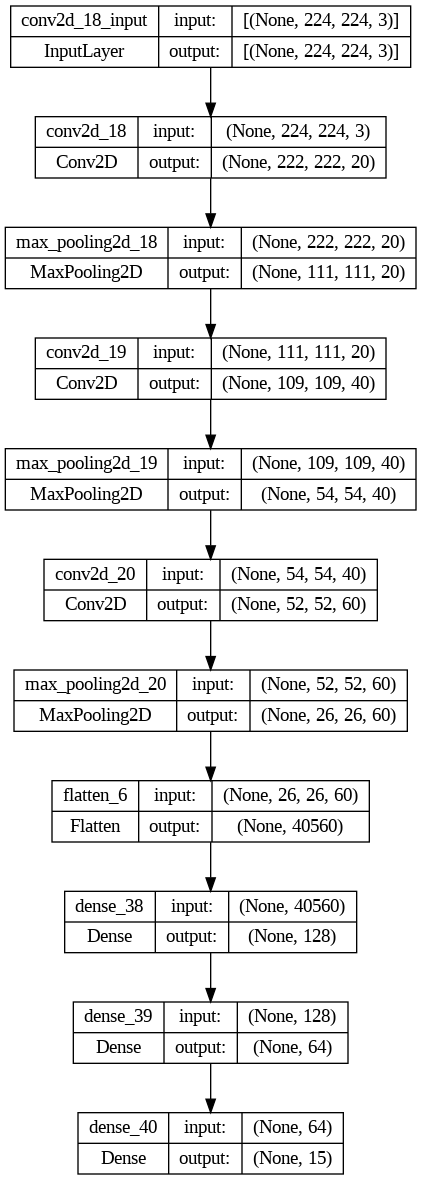

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model_4, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
model_M.save('/content/drive/MyDrive/4LAYER_1CLASSIFY_')

In [ ]:
plot_classification_report(labels ,y_pred_original_labels)


*Classification Report:
                  precision    recall  f1-score   support

   N_Raw_Banana       0.71      0.47      0.57       100
    N_Raw_Mango       0.75      0.72      0.73       100
   N_Raw_Orange       0.99      0.94      0.96       100
   N_Raw_Potato       0.63      0.95      0.76       100
   N_Raw_Tomato       0.70      0.83      0.76       100
  N_Ripe_Banana       0.49      0.60      0.54       100
   N_Ripe_Mango       0.72      0.94      0.82       100
  N_Ripe_Orange       0.50      1.00      0.66       100
  N_Ripe_Potato       0.74      0.61      0.67       100
  N_Ripe_Tomato       0.74      0.73      0.74       100
N_Rotten_Banana       0.00      0.00      0.00       100
 N_Rotten_Mango       0.54      0.21      0.30       100
N_Rotten_Orange       0.00      0.00      0.00       100
N_Rotten_Potato       0.58      0.76      0.66       100
N_Rotten_Tomato       0.43      0.72      0.54       100

       accuracy                           0.63      1500
   

()

# NN for 2 Models

## Data split

In [ ]:
X_train = np.stack(Train_df2['Image'].values)
Y_train_type = np.stack(Train_df2['Type'].values)
Y_train_Quality= np.stack(Train_df2['Quality'].values)
X_test = np.stack(Test_df2['Image'].values)
Y_test_type = np.stack(Test_df2['Type'].values)
Y_test_Quality= np.stack(Test_df2['Quality'].values)


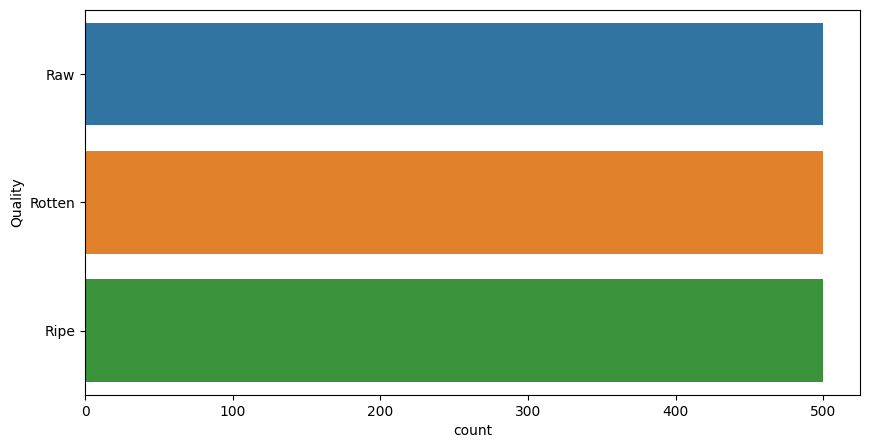

In [ ]:

plt.figure(figsize=(10, 5))
sns.countplot(y=Test_df2['Quality'])
plt.show()


## MNV2


In [ ]:
base_model_MNV2 = MobileNetV2(input_shape=(height, width, channels), include_top=False, weights='imagenet')
model_MNV2_Type = Sequential()
model_MNV2_Type.add(base_model_MNV2)
model_MNV2_Type.add(GlobalAveragePooling2D())
model_MNV2_Type.add(Dense(256, activation='relu'))
model_MNV2_Type.add(Dense(5, activation='softmax'))

In [ ]:
learning_rate = 0.001
model_MNV2_Type.compile(optimizer=Adam(lr=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
batch_size = 128
epochs = 10
MNV2_history_Type = model_MNV2_Type.fit(X_train, data_categorical(Y_train_type) , batch_size=128, epochs=epochs, validation_split=0.25)

Epoch 1/10
87/87 [==============================] - 16s 132ms/step - loss: 0.1080 - accuracy: 0.9649 - val_loss: 63.8348 - val_accuracy: 0.0000e+00
Epoch 2/10
87/87 [==============================] - 10s 118ms/step - loss: 0.0468 - accuracy: 0.9873 - val_loss: 25.0310 - val_accuracy: 0.0365
Epoch 3/10
87/87 [==============================] - 10s 118ms/step - loss: 0.0347 - accuracy: 0.9901 - val_loss: 24.4924 - val_accuracy: 0.0991
Epoch 4/10
87/87 [==============================] - 10s 118ms/step - loss: 0.0247 - accuracy: 0.9932 - val_loss: 23.6656 - val_accuracy: 0.0786
Epoch 5/10
87/87 [==============================] - 10s 118ms/step - loss: 0.0467 - accuracy: 0.9902 - val_loss: 19.3716 - val_accuracy: 0.0176
Epoch 6/10
87/87 [==============================] - 10s 119ms/step - loss: 0.0207 - accuracy: 0.9943 - val_loss: 6.7327 - val_accuracy: 0.5627
Epoch 7/10
87/87 [==============================] - 10s 118ms/step - loss: 0.0252 - accuracy: 0.9923 - val_loss: 20.0443 - val_accura

In [ ]:
y_pred_probs = model_MNV2_Type.predict(X_test)
y_pred_labels = np.argmax(y_pred_probs, axis=1)
labels = pd.Categorical(Y_test_type)
y_pred_original_labels = pd.Categorical.from_codes(y_pred_labels, categories=labels.categories)
accuracy = np.sum(np.where(y_pred_labels == labels.codes ,1,0))/1500
print("Test accuracy for MNV2 Type classifier classification:", accuracy)

47/47 [==============================] - 1s 8ms/step
Test accuracy for MNV2 Type classifier classification: 0.4533333333333333


In [ ]:
model_MNV2_Type.save('/content/drive/MyDrive/MNV2_TYPE')

In [ ]:
base_model_MNV2 = MobileNetV2(input_shape=(height, width, channels), include_top=False, weights='imagenet')
model_MNV2_Quality = Sequential()
model_MNV2_Quality.add(base_model_MNV2)
model_MNV2_Quality.add(GlobalAveragePooling2D())
model_MNV2_Quality.add(Dense(256, activation='relu'))
model_MNV2_Quality.add(Dense(3, activation='softmax'))

In [ ]:
learning_rate = 0.001
model_MNV2_Quality.compile(optimizer=Adam(lr=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
batch_size = 32
epochs = 10
MNV2_history_Quality = model_MNV2_Quality.fit(X_train, data_categorical(Y_train_Quality) , batch_size=128, epochs=epochs, validation_split=0.25)

Epoch 1/10
87/87 [==============================] - 16s 132ms/step - loss: 0.1205 - accuracy: 0.9542 - val_loss: 4.9446 - val_accuracy: 0.5078
Epoch 2/10
87/87 [==============================] - 10s 118ms/step - loss: 0.0312 - accuracy: 0.9896 - val_loss: 14.0925 - val_accuracy: 0.3690
Epoch 3/10
87/87 [==============================] - 10s 118ms/step - loss: 0.0359 - accuracy: 0.9902 - val_loss: 25.6564 - val_accuracy: 0.4600
Epoch 4/10
87/87 [==============================] - 10s 118ms/step - loss: 0.0272 - accuracy: 0.9913 - val_loss: 10.6146 - val_accuracy: 0.5951
Epoch 5/10
87/87 [==============================] - 10s 118ms/step - loss: 0.0234 - accuracy: 0.9944 - val_loss: 5.6800 - val_accuracy: 0.6405
Epoch 6/10
87/87 [==============================] - 10s 118ms/step - loss: 0.0091 - accuracy: 0.9971 - val_loss: 4.4214 - val_accuracy: 0.7075
Epoch 7/10
87/87 [==============================] - 10s 119ms/step - loss: 0.0135 - accuracy: 0.9959 - val_loss: 18.9315 - val_accuracy: 0.

In [ ]:
y_pred_probs = model_MNV2_Quality.predict(X_test)
y_pred_labels = np.argmax(y_pred_probs, axis=1)
labels = pd.Categorical(Y_test_Quality)
y_pred_original_labels = pd.Categorical.from_codes(y_pred_labels, categories=labels.categories)
accuracy = np.sum(np.where(y_pred_labels == labels.codes ,1,0))/1500
print("Test accuracy for MNV2 Quality classifier classification:", accuracy)

47/47 [==============================] - 1s 9ms/step
Test accuracy for MNV2 Quality classifier classification: 0.8353333333333334


In [ ]:
model_MNV2_Quality.save('/content/drive/MyDrive/MNV2_QUALITY')

## VGG16

In [ ]:
base_model_VGG16 = VGG16(input_shape=(height, width, channels), include_top=False, weights='imagenet')
model_VGG16_Type = Sequential()
model_VGG16_Type.add(base_model_MNV2)
model_VGG16_Type.add(GlobalAveragePooling2D())
model_VGG16_Type.add(Dense(256, activation='relu'))
model_VGG16_Type.add(Dense(5, activation='softmax'))
learning_rate = 0.001
model_VGG16_Type.compile(optimizer=SGD(lr=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
batch_size = 128
epochs = 10
validation_split=0.25
VGG16_Type_history = model_VGG16_Type.fit(X_train, data_categorical(Y_train_type) , batch_size=batch_size, epochs=epochs, validation_split=validation_split)

Epoch 1/10
87/87 [==============================] - 15s 134ms/step - loss: 0.6426 - accuracy: 0.8454 - val_loss: 15.9228 - val_accuracy: 0.0000e+00
Epoch 2/10
87/87 [==============================] - 10s 117ms/step - loss: 0.1777 - accuracy: 0.9964 - val_loss: 16.9092 - val_accuracy: 0.0000e+00
Epoch 3/10
87/87 [==============================] - 10s 117ms/step - loss: 0.1116 - accuracy: 0.9995 - val_loss: 16.6863 - val_accuracy: 0.0000e+00
Epoch 4/10
87/87 [==============================] - 10s 117ms/step - loss: 0.0804 - accuracy: 0.9995 - val_loss: 15.7913 - val_accuracy: 0.0000e+00
Epoch 5/10
87/87 [==============================] - 10s 117ms/step - loss: 0.0637 - accuracy: 0.9990 - val_loss: 14.4421 - val_accuracy: 0.0000e+00
Epoch 6/10
87/87 [==============================] - 10s 117ms/step - loss: 0.0523 - accuracy: 0.9995 - val_loss: 12.8371 - val_accuracy: 0.0016
Epoch 7/10
87/87 [==============================] - 10s 117ms/step - loss: 0.0452 - accuracy: 0.9994 - val_loss: 11.

In [ ]:
y_pred_probs = model_VGG16_Type.predict(X_test)
y_pred_labels = np.argmax(y_pred_probs, axis=1)
labels = pd.Categorical(Y_test_type)
y_pred_original_labels = pd.Categorical.from_codes(y_pred_labels, categories=labels.categories)
accuracy = np.sum(np.where(y_pred_labels == labels.codes ,1,0))/1500
print("Test accuracy for  Type classifier classification:", accuracy)

47/47 [==============================] - 1s 9ms/step
Test accuracy for VGG16 Type classifier classification: 0.7006666666666667


In [ ]:
base_model_VGG16 = VGG16(input_shape=(height, width, channels), include_top=False, weights='imagenet')
model_VGG16_Quality = Sequential()
model_VGG16_Quality.add(base_model_MNV2)
model_VGG16_Quality.add(GlobalAveragePooling2D())
model_VGG16_Quality.add(Dense(256, activation='relu'))
model_VGG16_Quality.add(Dense(3, activation='softmax'))
learning_rate = 0.001
model_VGG16_Quality.compile(optimizer=SGD(lr=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
batch_size = 128
epochs = 10
validation_split=0.25
VGG16_Type_history = model_VGG16_Quality.fit(X_train, data_categorical(Y_train_Quality) , batch_size=batch_size, epochs=epochs, validation_split=validation_split)

Epoch 1/10
87/87 [==============================] - 15s 133ms/step - loss: 0.6824 - accuracy: 0.7493 - val_loss: 1.3272 - val_accuracy: 0.4997
Epoch 2/10
87/87 [==============================] - 10s 117ms/step - loss: 0.4404 - accuracy: 0.8553 - val_loss: 1.4002 - val_accuracy: 0.5132
Epoch 3/10
87/87 [==============================] - 10s 117ms/step - loss: 0.3729 - accuracy: 0.8755 - val_loss: 1.4304 - val_accuracy: 0.5224
Epoch 4/10
87/87 [==============================] - 10s 117ms/step - loss: 0.3272 - accuracy: 0.8949 - val_loss: 1.4198 - val_accuracy: 0.5270
Epoch 5/10
87/87 [==============================] - 10s 117ms/step - loss: 0.3018 - accuracy: 0.9021 - val_loss: 1.4113 - val_accuracy: 0.5311
Epoch 6/10
87/87 [==============================] - 10s 117ms/step - loss: 0.2782 - accuracy: 0.9106 - val_loss: 1.3983 - val_accuracy: 0.5316
Epoch 7/10
87/87 [==============================] - 10s 117ms/step - loss: 0.2577 - accuracy: 0.9171 - val_loss: 1.3827 - val_accuracy: 0.5327

In [ ]:
y_pred_probs = model_VGG16_Quality.predict(X_test)
y_pred_labels = np.argmax(y_pred_probs, axis=1)
labels = pd.Categorical(Y_test_Quality)
y_pred_original_labels = pd.Categorical.from_codes(y_pred_labels, categories=labels.categories)
accuracy = np.sum(np.where(y_pred_labels == labels.codes ,1,0))/1500
print("Test accuracy for VGG16 Quality classifier classification:", accuracy)

47/47 [==============================] - 1s 9ms/step
Test accuracy for VGG16 Quality classifier classification: 0.7853333333333333


## 4 layer CNN


In [ ]:
# define the model
model_4_Type = Sequential()
model_4_Type.add(Conv2D(20, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(224, 224, 3)))
model_4_Type.add(MaxPooling2D(pool_size=(2, 2)))
model_4_Type.add(Conv2D(40, kernel_size=(3, 3), activation='sigmoid'))
model_4_Type.add(MaxPooling2D(pool_size=(2, 2)))
model_4_Type.add(Conv2D(60, kernel_size=(3, 3), activation='relu'))
model_4_Type.add(MaxPooling2D(pool_size=(2, 2)))
model_4_Type.add(Flatten())
model_4_Type.add(Dense(128, activation='relu'))
model_4_Type.add(Dense(64, activation='relu'))
model_4_Type.add(Dense(5, activation='softmax'))
model_4_Type.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
Type_4_history=model_4_Type.fit(X_train, data_categorical(Y_train_type) , epochs=10,batch_size=128,validation_split=0.25)

Epoch 1/10
88/88 [==============================] - 3s 31ms/step - loss: 0.0121 - accuracy: 0.9964 - val_loss: 3.9915 - val_accuracy: 0.7183
Epoch 2/10
88/88 [==============================] - 2s 26ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 4.0635 - val_accuracy: 0.7196
Epoch 3/10
88/88 [==============================] - 2s 27ms/step - loss: 9.9511e-04 - accuracy: 1.0000 - val_loss: 4.0682 - val_accuracy: 0.7196
Epoch 4/10
88/88 [==============================] - 2s 27ms/step - loss: 7.2936e-04 - accuracy: 1.0000 - val_loss: 4.0808 - val_accuracy: 0.7215
Epoch 5/10
88/88 [==============================] - 2s 27ms/step - loss: 5.6742e-04 - accuracy: 1.0000 - val_loss: 4.0898 - val_accuracy: 0.7228
Epoch 6/10
88/88 [==============================] - 2s 27ms/step - loss: 4.3278e-04 - accuracy: 1.0000 - val_loss: 4.1246 - val_accuracy: 0.7265
Epoch 7/10
88/88 [==============================] - 2s 27ms/step - loss: 3.1026e-04 - accuracy: 1.0000 - val_loss: 4.1426 - val_accuracy: 

In [ ]:
model_4_Type.save('/content/drive/MyDrive/4LAYER_TYPE')

In [ ]:
model_4_Quality = Sequential()
model_4_Quality.add(Conv2D(20, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(224, 224, 3)))
model_4_Quality.add(MaxPooling2D(pool_size=(2, 2)))
model_4_Quality.add(Conv2D(40, kernel_size=(3, 3), activation='sigmoid'))
model_4_Quality.add(MaxPooling2D(pool_size=(2, 2)))
model_4_Quality.add(Conv2D(60, kernel_size=(3, 3), activation='relu'))
model_4_Quality.add(MaxPooling2D(pool_size=(2, 2)))
model_4_Quality.add(Flatten())
model_4_Quality.add(Dense(128, activation='relu'))
model_4_Quality.add(Dense(64, activation='relu'))
model_4_Quality.add(Dense(3, activation='softmax'))
model_4_Quality.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
Quality_4_history=model_4_Quality.fit(X_train, data_categorical(Y_train_Quality) , epochs=10,batch_size=128,validation_split=0.25)

Epoch 1/10
88/88 [==============================] - 5s 33ms/step - loss: 0.9538 - accuracy: 0.6679 - val_loss: 4.7654 - val_accuracy: 0.1167
Epoch 2/10
88/88 [==============================] - 2s 27ms/step - loss: 0.4725 - accuracy: 0.8075 - val_loss: 6.2198 - val_accuracy: 0.3124
Epoch 3/10
88/88 [==============================] - 2s 26ms/step - loss: 0.3812 - accuracy: 0.8451 - val_loss: 5.8029 - val_accuracy: 0.3390
Epoch 4/10
88/88 [==============================] - 2s 27ms/step - loss: 0.3189 - accuracy: 0.8735 - val_loss: 7.8166 - val_accuracy: 0.4296
Epoch 5/10
88/88 [==============================] - 2s 27ms/step - loss: 0.2604 - accuracy: 0.8927 - val_loss: 9.9219 - val_accuracy: 0.4579
Epoch 6/10
88/88 [==============================] - 2s 27ms/step - loss: 0.2035 - accuracy: 0.9206 - val_loss: 15.3839 - val_accuracy: 0.4310
Epoch 7/10
88/88 [==============================] - 2s 27ms/step - loss: 0.1888 - accuracy: 0.9246 - val_loss: 16.2164 - val_accuracy: 0.4256
Epoch 8/10


# Load Datasets

In [ ]:
from keras.saving.legacy.save import load_model
model_MNV2 = load_model('/content/drive/MyDrive/MNV2_1CLASSIFY_')
model_MNV2_Type = load_model('/content/drive/MyDrive/MNV2_TYPE')
model_MNV2_Quality = load_model('/content/drive/MyDrive/MNV2_QUALITY')
model_VGG16 = load_model('/content/drive/MyDrive/VGG16_1CLASSIFY_')
model_VGG16_Type = load_model('/content/drive/MyDrive/VGG16_TYPE')
model_VGG16_Quality = load_model('/content/drive/MyDrive/VGG16_QUALITY')
model_4_CNN = load_model('/content/drive/MyDrive/4LAYER_1CLASSIFY_')
model_4_Type = load_model('/content/drive/MyDrive/4LAYER_TYPE (1)')
model_4_Quality = load_model('/content/drive/MyDrive/4LAYER_QUALITY')



In [ ]:
from PIL import Image
image_path='/content/tstresize.jpeg'
img = Image.open(image_path)
img = img.resize(img_shape)  # Resize the image to the desired size
img_array = np.array(img)
reshaped_img = img_array.reshape(1, 224, 224, 3)
y_pred_prob = model_VGG_FT.predict(reshaped_img)
y_pred_label = np.argmax(y_pred_prob, axis=1)
labels = pd.Categorical(Y_test)
y_pred_original_label = pd.Categorical.from_codes(y_pred_label, categories=labels.categories)
print("Orignal lableof the tested type is " + y_pred_original_label[0])

1/1 [==============================] - 0s 24ms/step
Orignal lableof the tested type is N_Rotten_Potato
